In [37]:
import pandas as pd
import numpy as np
import re
import string
import os
import codecs
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words

path = '/Users/deena/Documents/Spring_Module2/App_dev/App Work/Data'

In [27]:
df = pd.read_table(path+'/amazon_reviews/reviews_data_clean', delimiter='|')
df.replace(np.nan, '', regex=True, inplace = True)

In [28]:
df.head()

,asin,helpful,reviewText,overall,summary,description,title,categories_clean
0,0929619730,"[0, 0]",B-flax-D is a regular at our house. It does it...,5.0,Dpes the job well,Contains Organic Cold-Milled Flaxseed\nValuabl...,New Generation B-Flax-D,"Health & Personal Care, Vitamins & Dietary Sup..."
1,0978559088,"[1, 1]",Studies show that Resveratrol is poorly absorb...,4.0,"Fast shipping, good communication",Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup..."
2,0978559088,"[1, 1]",I started taking this after both my parents di...,5.0,Bioavailability is the key,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup..."
3,0978559088,"[0, 1]","I tried Nutrihill, but did not feel any of the...",1.0,Other Resveratrol Supplements are Better,Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup..."
4,0978559088,"[0, 0]",I really liked this product because it stayed ...,5.0,"I can't find this product any longer, and I wi...",Everyone knows that resveratrol is an amazing ...,Nutrihill Resveratrol Lozenges,"Health & Personal Care, Vitamins & Dietary Sup..."


In [29]:
df.title.nunique()

48278

## LDA

In [31]:
documents = df.summary + ' ' + df.reviewText

In [32]:
documents[1]

"Fast shipping, good communication Studies show that Resveratrol is poorly absorbed when taken by pill, but lozenges are very effectively absorbed. Hardly any companies are selling lozenges. This company promises 99% purity and has fast shipping and good communication. I can't comment on the quality of product because I'm not a chemist but they seem to be legitimate."

In [33]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [35]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    
no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

/Users/deena/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0:
taking day pills just started days time weeks week bottle
Topic 1:
great stuff value tastes service deal fast easy way thanks
Topic 2:
product recommend using excellent results highly happy used order purchase
Topic 3:
good stuff far pretty value quality tastes buy health think
Topic 4:
weight loss lost lose pounds appetite diet exercise garcinia lbs
Topic 5:
work did didn does doesn took tried notice try really
Topic 6:
oil fish omega krill fishy burps smell quality dha capsules
Topic 7:
works really stuff does better helps tried like recommend actually
Topic 8:
love stuff kids awesome absolutely amazing buy really helps recommend
Topic 9:
price quality buy amazon brand shipping store order reasonable excellent
Topic 10:
energy feel better gives boost difference appetite like feeling level
Topic 11:
stars gave excellent ok reason giving expected rate fast given
Topic 12:
vitamin vitamins easy multi swallow d3 daily calcium stomach kids
Topic 13:
34 say just don ingredients sa

In [ ]:
# LDA may not work. WHY?
 # Usually used for summarizing a corpus
 # Or for finding a topic for the ENTIRE corpus. For ex, here the topic would be 'health supplements'
 # Cannot extract smaller topics such as cost, price etc. since LDA gives a summary

## Rules based for topics

In [38]:
#nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/deena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
nltk_stpwd = stopwords.words('english')
stop_words_stpwd = get_stop_words('en')
merged_stopwords = list(set(nltk_stpwd + stop_words_stpwd))

In [44]:
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    words = [w for w in words if len(w) > 2]
    words = [w.lower() for w in words]
    goodwords = [w for w in words if w not in merged_stopwords]

    return goodwords

In [53]:
reviews = df.summary + ' ' + df.reviewText
reviews_tokenized = []
for r in reviews:
    reviews_tokenized.append(words(r))

In [52]:
# Synonyms (This package is useless, not using)
#from PyDictionary import PyDictionary
#dictionary=PyDictionary()

In [116]:
# Let's try for one product category only, which to pick?

df_categories = df.categories_clean.str.split(', ', expand = True).loc[:,:4]
df_categories[3].isnull().sum() # 15% nulls
df_categories.groupby(df_categories[3]).count()[0].reset_index().sort_values(0, ascending = False).head()

,3,0
109,Supplements,91138
38,Digestive Supplements,51420
80,Multiple Vitamin-Mineral Supplements,42864
5,Appetite Control & Suppressants,40246
44,Essential Fatty Acids,27148


In [121]:
# Let's take 'Supplements'
# Filtering on supplements:

df_supplements = df[df_categories[3] == 'Supplements']
reviews_tokenized = np.array(reviews_tokenized)
reviews_tokenized_supplements = reviews_tokenized[df_categories[3] == 'Supplements']

In [129]:
# tfidf won't work for reviews probably (each document is too small and may not have repeasting words even)

# Trying just counter of words:

from itertools import chain
import collections

unlisted = list(chain(*reviews_tokenized_supplements))
counter = collections.Counter(unlisted)
print(counter.most_common()[:100])

[('product', 81640), ('weight', 58576), ('taking', 29982), ('great', 29710), ('lost', 27678), ('work', 25260), ('like', 23841), ('loss', 23125), ('good', 22925), ('day', 22577), ('energy', 22433), ('really', 21614), ('one', 21534), ('take', 20978), ('pounds', 20943), ('feel', 20096), ('results', 19614), ('lose', 19099), ('appetite', 19055), ('works', 19003), ('diet', 16978), ('weeks', 16519), ('pills', 16431), ('get', 16194), ('using', 15455), ('week', 15060), ('time', 15058), ('also', 14586), ('lbs', 14327), ('eat', 13910), ('much', 13669), ('try', 13636), ('first', 13060), ('see', 12993), ('coffee', 12899), ('recommend', 12845), ('bottle', 12828), ('started', 12332), ('help', 12308), ('well', 12200), ('exercise', 12146), ('green', 11610), ('far', 11469), ('fat', 11437), ('days', 11404), ('tried', 11299), ('month', 11100), ('love', 11096), ('eating', 10824), ('two', 10568), ('better', 10369), ('even', 9817), ('use', 9734), ('give', 9670), ('pill', 9651), ('money', 9632), ('effects', 9

In [128]:
counter # That's the total unique words we have

41754

In [152]:
# Finding common words. List below
len([text for text in df_supplements.reviewText if 'help' in text])

# cost - 1005
# price - 3739
# ship - 2094
# pack - 1939
# pricey - 21
# cheap - 1069
# quality - 1415
# return - 1087
# deliver - 1115
# packag - 1186

# Efficacy General:
    # work - 33400 
    # recommend - 15619
    # love - 6419
    # help - 20022

20022

In [159]:
# Number of reviews that talk about these two stuff:
non_efficacy_list = ['cost', 'price', 'ship', 'pack', 'pricey', 'cheap', 'quality', 'return', 'deliver', 'packag']
efficacy_list = ['work', 'recommend', 'love', 'help']

print(len([review for word in non_efficacy_list for review in df_supplements.reviewText if word in review]))
print(len([review for word in efficacy_list for review in df_supplements.reviewText if word in review]))
print(len(df_supplements))

# Conclusion: this list covers nearly 99% of reviews (not checked for overlaps), 
# with 16% talking about non efficacy and 82% talking about efficacy.

14819
75460
91138


In [171]:
# Efficacy: Good vs Bad?
# Rating 4 and above: Good, else Bad

# Good reviews
print ("Efficacy Good: ", sum([1 for word in efficacy_list for review in df_supplements[df_supplements.overall >= 4.0].reviewText 
     if word in review]))
print ("Non Efficacy Good: ", sum([1 for word in non_efficacy_list for review in df_supplements[df_supplements.overall >= 4.0].reviewText 
     if word in review]))

# Bad reviews
print ("Efficacy Bad: ", sum([1 for word in efficacy_list for review in df_supplements[df_supplements.overall < 4.0].reviewText 
     if word in review]))
print ("Non Efficacy Bad: ", sum([1 for word in non_efficacy_list for review in df_supplements[df_supplements.overall < 4.0].reviewText 
     if word in review]))

Efficacy Good:  57337
Non Efficacy Good:  10137
Efficacy Bad:  18123
Non Efficacy Bad:  4682


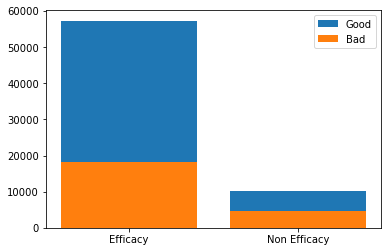

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline

ind = np.arange(2) 
Good = [57337, 10137]
Bad = [18123, 4682]
#No_mention = [91138 - 57337 - 18123, 91138 - 10137 - 4682]

p1 = plt.bar(ind, Good)
p2 = plt.bar(ind, Bad)
#p3 = plt.bar(ind, No_mention)
plt.xticks(ind, ('Efficacy', 'Non Efficacy'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Good', 'Bad'))

plt.show()

## Reviews not matching to any of the words in the list can be tackled through embeddings

## Trying spacy to get the sentiment